# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [5]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [6]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Inspecting the matrix structure!

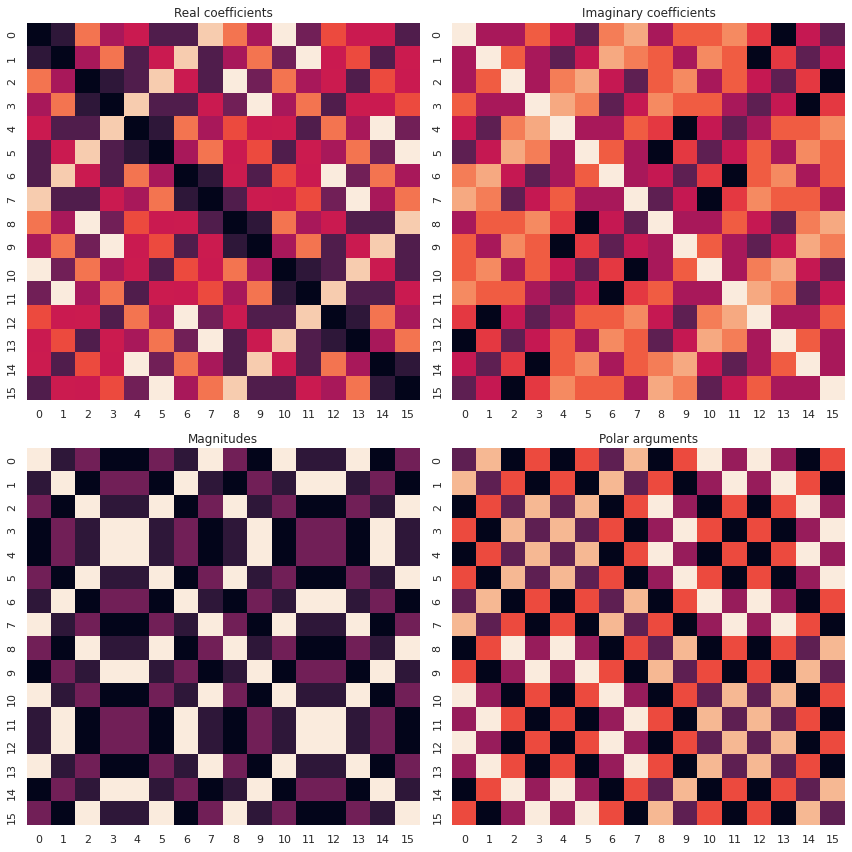

In [67]:
A = np.matrix(U)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(A.real, cbar=False)
plt.title('Real coefficients')

plt.subplot(2, 2, 2)
sns.heatmap(A.imag, cbar=False)
plt.title('Imaginary coefficients')

plt.subplot(2, 2, 3)
sns.heatmap(np.square(np.abs(A)), cbar=False)
plt.title('Magnitudes')

plt.subplot(2, 2, 4)
sns.heatmap(np.arctan(A.real/A.imag), cbar=False)
plt.title('Polar arguments')

plt.tight_layout()
plt.show()

This seems to exhibit some symmetry, but without a clear decomposition. A hint from exercise 1 suggests a hadamard transform and we inspect the transformed operator.

In [8]:
H = np.matrix([
    [1, 1],
    [1, -1],
])/np.sqrt(2)

H2 = np.kron(H, H)
H4 = np.kron(H2, H2)

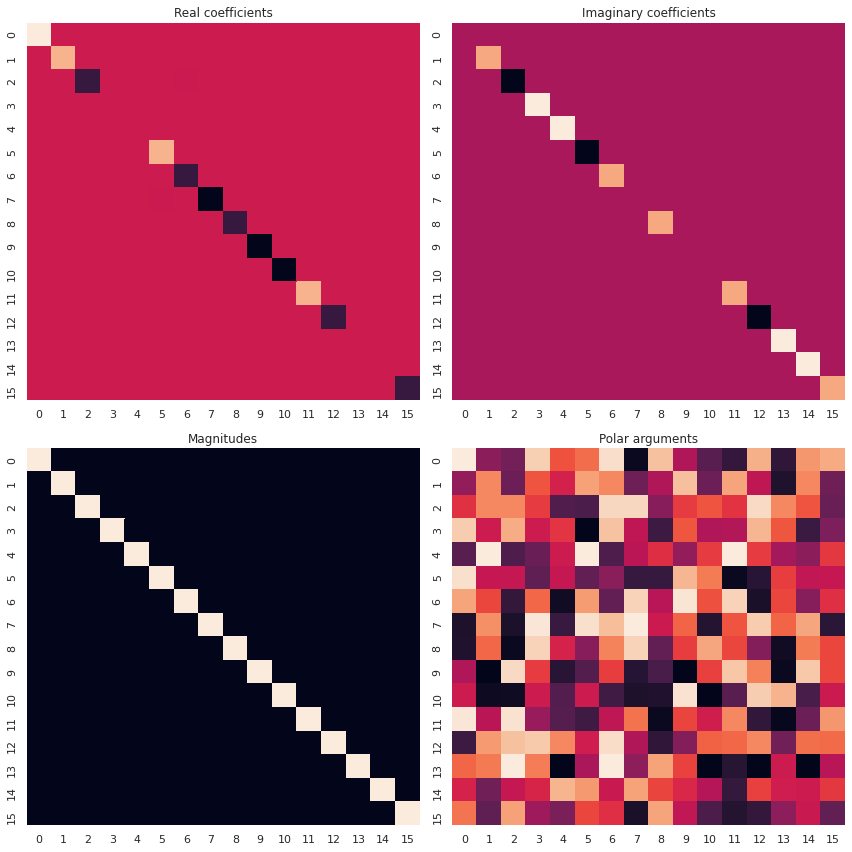

In [68]:
A = np.matrix(H4*U*H4)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.heatmap(A.real, cbar=False)
plt.title('Real coefficients')

plt.subplot(2, 2, 2)
sns.heatmap(A.imag, cbar=False)
plt.title('Imaginary coefficients')

plt.subplot(2, 2, 3)
sns.heatmap(np.square(np.abs(A)), cbar=False)
plt.title('Magnitudes')

plt.subplot(2, 2, 4)
sns.heatmap(np.arctan(A.real/A.imag), cbar=False)
plt.title('Polar arguments')

plt.tight_layout()
plt.show()

The transformed operator seems to only contain diagonal entries and is a good candidate for transpilation! 

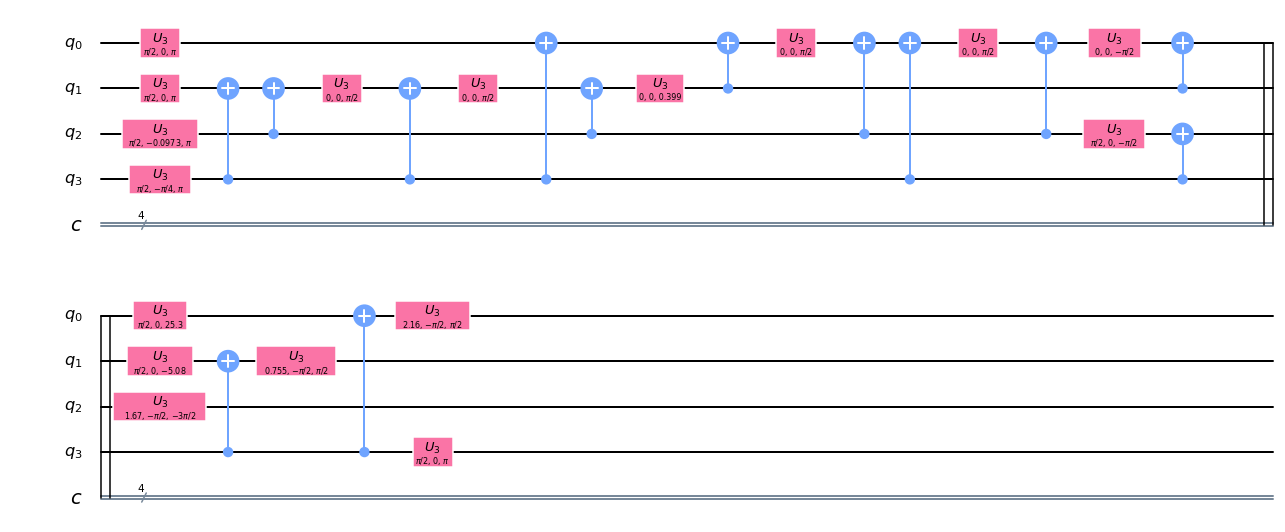

In [69]:
##### build your quantum circuit here
qc = QuantumCircuit(4, 4)

# apply operations to your quantum circuit here
from qiskit import transpile

qc.h([0,1,2,3])
qc.iso(H4*U*H4, [0, 1, 2, 3], [])
qc.h([0,1,2,3])

qc = transpile(
    circuits = qc,
    basis_gates = ['u3', 'cx'],
    optimization_level = 2, # As epsilon is rather large, a lower optimization level leads to a lower gate cost
)

qc.draw()

Indeed, this produces a ahallow circuit with minimal gate usage.

In [70]:
##### check your quantum circuit by running the next line
check_circuit(qc)

Circuit stats:
||U-V||_2 = 9.942226695819332e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 147

Great! Your circuit meets all the constrains.
Your score is 147. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [34]:
# Send the circuit as the final answer, can re-submit at any time
submit_circuit(qc) 